In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm

443


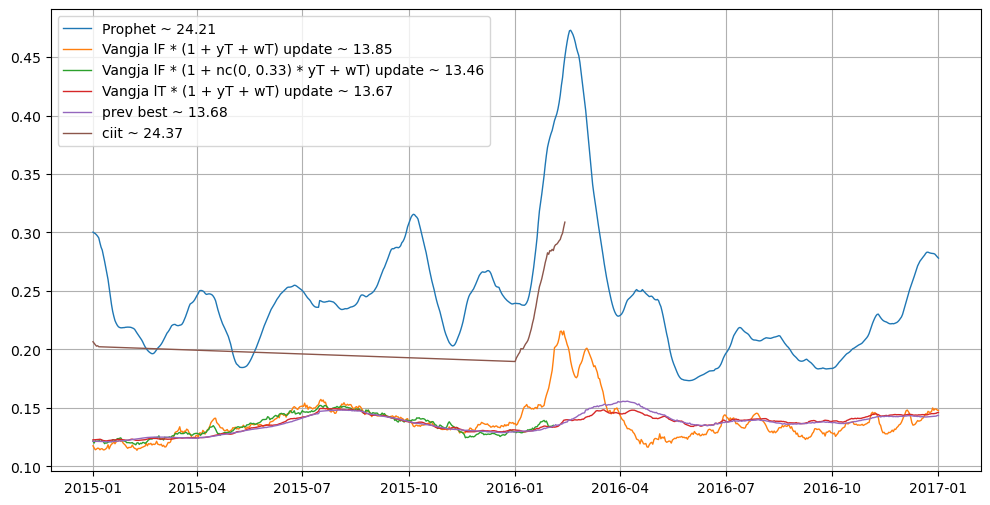

In [4]:
# test10 - NC * yT + wF
# test11 - BC * yT + wT
prophet_parent_path = Path("./") / "out" / "prophet"
vangja_parent_path = Path("./") / "out" / "vangja"

paths = [
    prophet_parent_path / "test2",
    # vangja_parent_path / "test20",
    vangja_parent_path / "test21",
    vangja_parent_path / "test22",
    vangja_parent_path / "test23",
    vangja_parent_path / "test14",
    vangja_parent_path / "test_ciit_0",
]
labels = [
    "Prophet",
    # "Vangja lF * (1 + yT + wT)",
    "Vangja lF * (1 + yT + wT) update",
    "Vangja lF * (1 + nc(0, 0.33) * yT + wT) update",
    "Vangja lT * (1 + yT + wT) update",
    "prev best",
    "ciit"
]
index = None

for point in pd.date_range("2015-01-01", "2017-01-01"):
    point_str = f"{point.year}-{'' if point.month > 9 else '0'}{point.month}-{'' if point.day > 9 else '0'}{point.day}"
    model_name = f"prophet_{point_str}_multiplicative_lt0_w"
    csv_path = paths[0] / f"{model_name}.csv"
    vangja_path = paths[1] / f"{point_str}.csv"
    if not csv_path.is_file() or not vangja_path.is_file():
        continue

    index_1 = pd.read_csv(csv_path, index_col=0).index
    index_2 = pd.read_csv(vangja_path, index_col=0).index
    index_1 = index_1.intersection(index_2)
    if index is None:
        index = index_1

    index = index.intersection(index_1)

print(len(index))
plt.figure(figsize=(12, 6))

for idx, (path, label) in enumerate(zip(paths, labels)):
    dates = []
    mapes = []
    for point in pd.date_range("2015-01-01", "2017-01-01"):
        point_str = f"{point.year}-{'' if point.month > 9 else '0'}{point.month}-{'' if point.day > 9 else '0'}{point.day}"
        csv_path = (
            path / f"prophet_{point_str}_multiplicative_lt0_w.csv"
            if idx == 0
            else path / f"{point_str}.csv"
        )

        if not csv_path.is_file():
            continue

        dates.append(point)
        mapes.append(pd.read_csv(csv_path, index_col=0)["mape"].mean())

    plt.plot(dates, mapes, lw=1, label=f"{label} ~ {100 * sum(mapes) / len(mapes):.2f}")

plt.grid()
plt.legend()

442


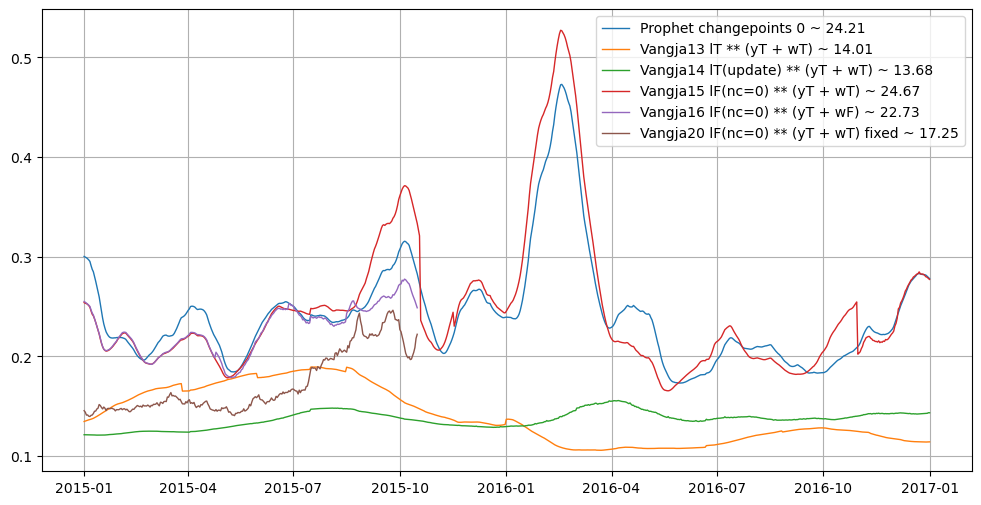

In [2]:
# test10 - NC * yT + wF
# test11 - BC * yT + wT
dates = []
dates2 = []
vangja_dates = []
vangja2_dates = []
vangja3_dates = []
vangja4_dates = []
vangja5_dates = []
vangja6_dates = []
vangja7_dates = []
vangja8_dates = []
mapes = []
mapes2 = []
vangja_mapes = []
vangja2_mapes = []
vangja3_mapes = []
vangja4_mapes = []
vangja5_mapes = []
vangja6_mapes = []
vangja7_mapes = []
vangja8_mapes = []

index = None

for point in pd.date_range("2015-01-01", "2017-01-01"):
    point_str = f"{point.year}-{'' if point.month > 9 else '0'}{point.month}-{'' if point.day > 9 else '0'}{point.day}"
    model_name = f"prophet_{point_str}_multiplicative_w"
    csv_path = Path("./") / "out" / "prophet" / "test" / f"{model_name}.csv"
    vangja_path = Path("./") / "out" / "vangja" / "test10" / f"{point_str}.csv"
    if not csv_path.is_file() or not vangja_path.is_file():
        continue

    index_1 = pd.read_csv(csv_path, index_col=0).index
    index_2 = pd.read_csv(vangja_path, index_col=0).index
    index_1 = index_1.intersection(index_2)
    if index is None:
        index = index_1

    index = index.intersection(index_1)

print(len(index))
prophet_metrics_per_ticker = {}
vangja_metrics_per_ticker = {}

for point in pd.date_range("2015-01-01", "2017-01-01"):
    point_str = f"{point.year}-{'' if point.month > 9 else '0'}{point.month}-{'' if point.day > 9 else '0'}{point.day}"
    model_name = f"prophet_{point_str}_multiplicative_w"
    csv_path = Path("./") / "out" / "prophet" / "test" / f"{model_name}.csv"
    csv2_path = Path("./") / "out" / "prophet" / "test2" / f"prophet_{point_str}_multiplicative_lt0_w.csv"
    vangja_path = Path("./") / "out" / "vangja" / "test10" / f"{point_str}.csv"
    vangja2_path = Path("./") / "out" / "vangja" / "test11" / f"{point_str}.csv"
    vangja3_path = Path("./") / "out" / "vangja" / "test12" / f"{point_str}.csv"
    vangja4_path = Path("./") / "out" / "vangja" / "test13" / f"{point_str}.csv"
    vangja5_path = Path("./") / "out" / "vangja" / "test14" / f"{point_str}.csv"
    vangja6_path = Path("./") / "out" / "vangja" / "test15" / f"{point_str}.csv"
    vangja7_path = Path("./") / "out" / "vangja" / "test16" / f"{point_str}.csv"
    vangja8_path = Path("./") / "out" / "vangja" / "test20" / f"{point_str}.csv"

    if not csv_path.is_file():
        continue

    dates.append(point)
    prophet_metrics = pd.read_csv(csv_path, index_col=0)
    mapes.append(prophet_metrics["mape"].mean())

    if not vangja_path.is_file():
        continue

    vangja_metrics = pd.read_csv(vangja_path, index_col=0)
    vangja_dates.append(point)
    vangja_mapes.append(vangja_metrics["mape"].mean())

    # for ticker in index:
    #     prophet_metrics_per_ticker[ticker] = prophet_metrics_per_ticker.get(
    #         ticker, []
    #     ) + [prophet_metrics.loc[ticker]["mape"]]
    #     vangja_metrics_per_ticker[ticker] = vangja_metrics_per_ticker.get(
    #         ticker, []
    #     ) + [vangja_metrics.loc[ticker]["mape"]]

    if not vangja2_path.is_file():
        continue

    vangja2_metrics = pd.read_csv(vangja2_path, index_col=0)
    vangja2_dates.append(point)
    vangja2_mapes.append(vangja2_metrics["mape"].mean())

    if not vangja3_path.is_file():
        continue

    vangja3_metrics = pd.read_csv(vangja3_path, index_col=0)
    vangja3_dates.append(point)
    vangja3_mapes.append(vangja3_metrics["mape"].mean())

    if not csv2_path.is_file():
        continue

    dates2.append(point)
    prophet_metrics = pd.read_csv(csv2_path, index_col=0)
    mapes2.append(prophet_metrics["mape"].mean())

    if not vangja4_path.is_file():
        continue

    vangja4_metrics = pd.read_csv(vangja4_path, index_col=0)
    vangja4_dates.append(point)
    vangja4_mapes.append(vangja4_metrics["mape"].mean())

    if not vangja5_path.is_file():
        continue

    vangja5_metrics = pd.read_csv(vangja5_path, index_col=0)
    vangja5_dates.append(point)
    vangja5_mapes.append(vangja5_metrics["mape"].mean()) 

    if not vangja6_path.is_file():
        continue

    vangja6_metrics = pd.read_csv(vangja6_path, index_col=0)
    vangja6_dates.append(point)
    vangja6_mapes.append(vangja6_metrics["mape"].mean()) 

    if not vangja7_path.is_file():
        continue

    vangja7_metrics = pd.read_csv(vangja7_path, index_col=0)
    vangja7_dates.append(point)
    vangja7_mapes.append(vangja7_metrics["mape"].mean()) 

    if not vangja8_path.is_file():
        continue

    vangja8_metrics = pd.read_csv(vangja8_path, index_col=0)
    vangja8_dates.append(point)
    vangja8_mapes.append(vangja8_metrics["mape"].mean()) 

plt.figure(figsize=(12, 6))
# plt.plot(dates, mapes, lw=1, label=f"Prophet ~ {100 * sum(mapes) / len(mapes):.2f}")
# plt.plot(
#     vangja_dates,
#     vangja_mapes,
#     lw=1,
#     label=f"Vangja10 lF ** (NC * yT + wF) ~ {100 * sum(vangja_mapes) / len(vangja_mapes):.2f}",
# )
# plt.plot(
#     vangja2_dates,
#     vangja2_mapes,
#     lw=1,
#     label=f"Vangja11 lF ** (BC * yT + wT) ~ {100 * sum(vangja2_mapes) / len(vangja2_mapes):.2f}",
# )
# plt.plot(
#     vangja3_dates,
#     vangja3_mapes,
#     lw=1,
#     label=f"Vangja12 lF ** (yT + wT) ~ {100 * sum(vangja3_mapes) / len(vangja3_mapes):.2f}",
# )

plt.plot(dates2, mapes2, lw=1, label=f"Prophet changepoints 0 ~ {100 * sum(mapes2) / len(mapes2):.2f}")
plt.plot(
    vangja4_dates,
    vangja4_mapes,
    lw=1,
    label=f"Vangja13 lT ** (yT + wT) ~ {100 * sum(vangja4_mapes) / len(vangja4_mapes):.2f}",
)
plt.plot(
    vangja5_dates,
    vangja5_mapes,
    lw=1,
    label=f"Vangja14 lT(update) ** (yT + wT) ~ {100 * sum(vangja5_mapes) / len(vangja5_mapes):.2f}",
)
plt.plot(
    vangja6_dates,
    vangja6_mapes,
    lw=1,
    label=f"Vangja15 lF(nc=0) ** (yT + wT) ~ {100 * sum(vangja6_mapes) / len(vangja6_mapes):.2f}",
)
plt.plot(
    vangja7_dates,
    vangja7_mapes,
    lw=1,
    label=f"Vangja16 lF(nc=0) ** (yT + wF) ~ {100 * sum(vangja7_mapes) / len(vangja7_mapes):.2f}",
)
plt.plot(
    vangja8_dates,
    vangja8_mapes,
    lw=1,
    label=f"Vangja20 lF(nc=0) ** (yT + wT) fixed ~ {100 * sum(vangja8_mapes) / len(vangja8_mapes):.2f}",
)
plt.grid()
plt.legend()

In [59]:
mapes2

[0.30028420106923037,
 0.2996746882466292,
 0.2990015223634076,
 0.29804571155288956,
 0.2968213489993706,
 0.2953252513353253,
 0.2911225051872781,
 0.287390615310961,
 0.28489789587710956,
 0.2803691177861993,
 0.2754927208578266,
 0.2703685712497729,
 0.265013415791452,
 0.259841731601971,
 0.25273229835301225,
 0.24516369242183036,
 0.23840620084792039,
 0.23263039107943098,
 0.2283748102230077,
 0.2247240996523644,
 0.2224905177791135,
 0.22066506593187754,
 0.21938240674198628,
 0.2187833834689457,
 0.21852215835347538,
 0.21849391883361788,
 0.21867445908723415,
 0.21867734155448929,
 0.2189296987891544,
 0.2190284239407795,
 0.21910445394862194,
 0.21908805004730597,
 0.21901482452040677,
 0.218814589918046,
 0.2183760283885764,
 0.21797574115893395,
 0.21720446438916308,
 0.21559841020222933,
 0.21408988215110478,
 0.2126327561787606,
 0.21125996424835608,
 0.20985906549568298,
 0.2082676829061209,
 0.20644528232585557,
 0.20429290358376828,
 0.20239487293575598,
 0.2007784544

In [60]:
vangja6_mapes

[0.2540535771224329,
 0.25335571377210503,
 0.2530171881316092,
 0.2522421849968631,
 0.2510415398098593,
 0.24939418332252708,
 0.24562171118764403,
 0.2423564457775238,
 0.24070239064916119,
 0.23775702318682013,
 0.2343330883163953,
 0.23046117013488307,
 0.22621328974488156,
 0.22252361547364974,
 0.21759223050931065,
 0.2131673861229836,
 0.20976937751577912,
 0.20729339897995733,
 0.20607876713857864,
 0.20536090112204247,
 0.20557982040444683,
 0.20608324980092815,
 0.2068246656987105,
 0.20786893231316236,
 0.20901318129915894,
 0.2103106015054504,
 0.21180637131471305,
 0.21322984237340487,
 0.21490299215375644,
 0.21699140970503825,
 0.21862732589963843,
 0.2201308062100042,
 0.22151203325196206,
 0.2228034483890568,
 0.22338618450564676,
 0.2236930827115296,
 0.22342440471757635,
 0.22201253993430656,
 0.22064045744034694,
 0.21931084556508532,
 0.2180594190633929,
 0.2166281542545549,
 0.21513013130541392,
 0.2131086899417484,
 0.21042852832520925,
 0.20788512862895683,
 0.

In [63]:
vangja7_mapes

[0.25518754970404,
 0.25436481628376195,
 0.2535138269651557,
 0.2525422286826918,
 0.2514524160642913,
 0.2501777027215937,
 0.24660734950632887,
 0.24355159235964854,
 0.2415333413497895,
 0.23790495637381262,
 0.23419110003540727,
 0.23041272832360496,
 0.2265583951102312,
 0.22311291941993505,
 0.21845662681615252,
 0.21373096893975602,
 0.20996634877126183,
 0.20740405954749325,
 0.20631309362608932,
 0.20583201466364429,
 0.20608249004026427,
 0.2066360855287957,
 0.2072576410586502,
 0.20829206794777608,
 0.2095181644109423,
 0.21097072624900695,
 0.21263462434030592,
 0.21393478625195908,
 0.21546585019074063]

In [39]:
(pd.DataFrame(prophet_metrics_per_ticker).mean() - pd.DataFrame(vangja_metrics_per_ticker).mean()).sort_values(ascending=False).iloc[:380]

CF      0.080433
UAA     0.067014
WYNN    0.061479
MOS     0.057299
FCX     0.052467
          ...   
DHR     0.003513
EIX     0.003484
RSG     0.003438
PSX     0.003223
LYV     0.003138
Length: 380, dtype: float64

In [56]:
ti = pd.DataFrame(prophet_metrics_per_ticker).mean().sort_values().index

In [61]:
pd.DataFrame(prophet_metrics_per_ticker).mean()["UNH"], pd.DataFrame(vangja_metrics_per_ticker).mean()["UNH"]

(0.24384666203119232, 0.21951790229681753)

In [69]:
(
    (
        pd.DataFrame(prophet_metrics_per_ticker).mean().loc[ti]
        - pd.DataFrame(vangja_metrics_per_ticker).mean().loc[ti]
    )
    / pd.DataFrame(prophet_metrics_per_ticker).mean().loc[ti]
).sort_values(ascending=False)

UNH     0.099771
CF      0.096638
LEG     0.093062
CAH     0.091181
TPR     0.089200
          ...   
MA     -0.031540
PG     -0.034188
CTAS   -0.034577
V      -0.046210
TAP    -0.054254
Length: 442, dtype: float64

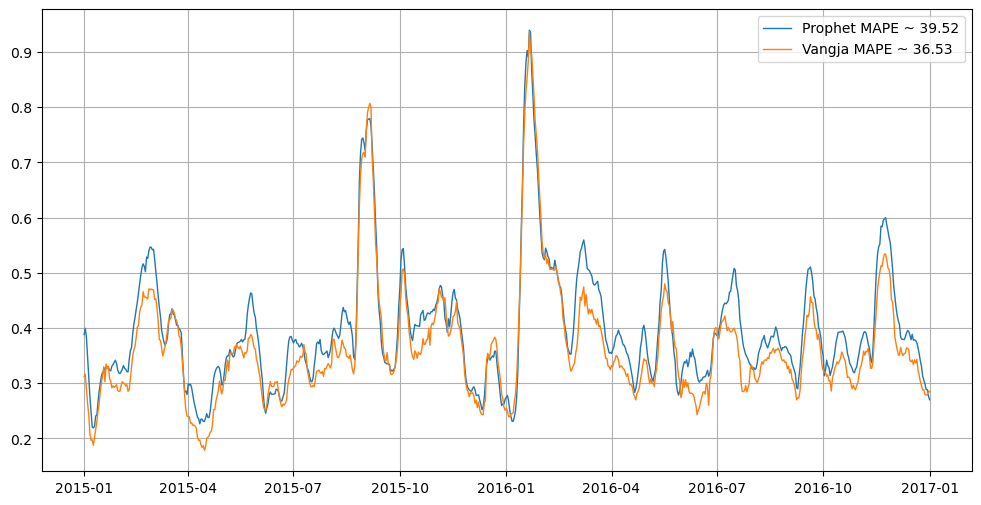

In [72]:

# best = (pd.DataFrame(prophet_metrics_per_ticker).mean() - pd.DataFrame(vangja_metrics_per_ticker).mean()).sort_values(ascending=False).iloc[:200].index
best = (
    (
        pd.DataFrame(prophet_metrics_per_ticker).mean().loc[ti]
        - pd.DataFrame(vangja_metrics_per_ticker).mean().loc[ti]
    )
    / pd.DataFrame(prophet_metrics_per_ticker).mean().loc[ti]
).sort_values(ascending=False).iloc[:50].index
dates = []
vangja_dates = []
mapes = []
vangja_mapes = []

for point in pd.date_range("2015-01-01", "2017-01-01"):
    point_str = f"{point.year}-{'' if point.month > 9 else '0'}{point.month}-{'' if point.day > 9 else '0'}{point.day}"
    model_name = f"prophet_{point_str}_multiplicative_w"
    csv_path = Path("./") / "out" / "prophet" / "test" / f"{model_name}.csv"
    vangja_path = Path("./") / "out" / "vangja" / "test10" / f"{point_str}.csv"
    if not csv_path.is_file() or not vangja_path.is_file():
        continue

    dates.append(point)
    prophet_metrics = pd.read_csv(csv_path, index_col=0).loc[best]
    mapes.append(prophet_metrics["mape"].mean())
    if not vangja_path.is_file():
        continue

    vangja_metrics = pd.read_csv(vangja_path, index_col=0).loc[best]
    vangja_dates.append(point)
    vangja_mapes.append(vangja_metrics["mape"].mean())

plt.figure(figsize=(12, 6))
plt.plot(dates, mapes, lw=1, label=f"Prophet MAPE ~ {100 * sum(mapes) / len(mapes):.2f}")
plt.plot(vangja_dates, vangja_mapes, lw=1, label=f"Vangja MAPE ~ {100 * sum(vangja_mapes) / len(vangja_mapes):.2f}")
plt.grid()
plt.legend()

In [37]:
prophet_metrics_per_ticker["NRG"]

[0.6602629960815104,
 0.8690505326626856,
 0.664686055294643,
 1.0929526245791368,
 0.9524554900491292]

In [186]:
pd.DataFrame(vangja_metrics_per_ticker).mean().sort_values()

CLX     0.120702
RSG     0.154542
PEP     0.183628
T       0.188831
LMT     0.191420
          ...   
CF      0.986732
NCLH    1.021120
MU      1.025952
WMB     1.117796
FCX     1.489121
Length: 442, dtype: float64

In [24]:
pd.Series(mapes).describe()

count    664.000000
mean       0.393368
std        0.117633
min        0.224099
25%        0.316248
50%        0.365206
75%        0.437891
max        1.000289
dtype: float64

In [25]:
pd.Series(vangja_mapes).describe()

count    664.000000
mean       0.376859
std        0.120885
min        0.205629
25%        0.297395
50%        0.348706
75%        0.414936
max        1.002883
dtype: float64

In [63]:
idx = -3
mapes[idx], vangja_mapes[idx]

(0.29075288763021745, 0.28838827693962354)